# <center> MERA

conv=2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorcircuit as tc
from jax.config import config

config.update("jax_enable_x64", True)
tc.set_backend("tensorflow")
tc.set_dtype("complex128")

('complex128', 'float64')

## energy
$$ \hat{H}_{Ising}=J\sum_{i}{Z_{i}Z_{i+1}}-B_{x}\sum_{i}{X_{i}} $$

In [2]:
# j=1, Bx=1
def energy(c: tc.Circuit, j: float = 1.0, h: float = 1.0):
    e = 0.0
    n = c._nqubits
    for i in range(n):
        e -= h * c.expectation((tc.gates.x(), [i]))  # <X_i>
    for i in range(n-1):  
        e += j * c.expectation(
            (tc.gates.z(), [i]), (tc.gates.z(), [i+1])
        )  # <Z_i Z_{i+1}>
    return tc.backend.real(e)

## MERA net

In [8]:
def MERA(params, n):
    params = tc.backend.cast(params, "complex128")
    c = tc.Circuit(n)
    
    idx = 0
    
    for i in range(n):
        c.rx(i, theta=params[2*i])
        c.rz(i, theta=params[2*i+1])
    idx += 2*n
    
    for n_layer in range(1, int(np.log2(n))+1):
        n_qubit = 2**n_layer   # 参与计算的qubit数
        step = int(n / n_qubit)
        '''
        if n_layer == 1:
            for i in range(0, n, step):
                c.rx(i, theta=params[0])
                c.rz(i, theta=params[1])
                idx += 2
        else:
            for i in range(step, n, 2*step):
                c.rx(i, theta=params[idx])
                c.rz(i, theta=params[idx+1])
                idx += 2
        '''  
        # even    
        for i in range(step, n-step, 2*step):
            c.exp1(i, i+step, theta=params[idx], unitary=tc.gates._xx_matrix)
            c.exp1(i, i+step, theta=params[idx+1], unitary=tc.gates._zz_matrix)
            idx += 2
        
        # odd   
        for i in range(0, n, 2*step):
            c.exp1(i, i+step, theta=params[idx], unitary=tc.gates._xx_matrix)
            c.exp1(i, i+step, theta=params[idx+1], unitary=tc.gates._zz_matrix)
            idx += 2
        
        for i in range(0, n, step):
            c.rx(i, theta=params[idx])
            c.rz(i, theta=params[idx+1])
            idx += 2
        
        # c.barrier()

    # measure
    e = energy(c)
    #return c, idx
    return e

144


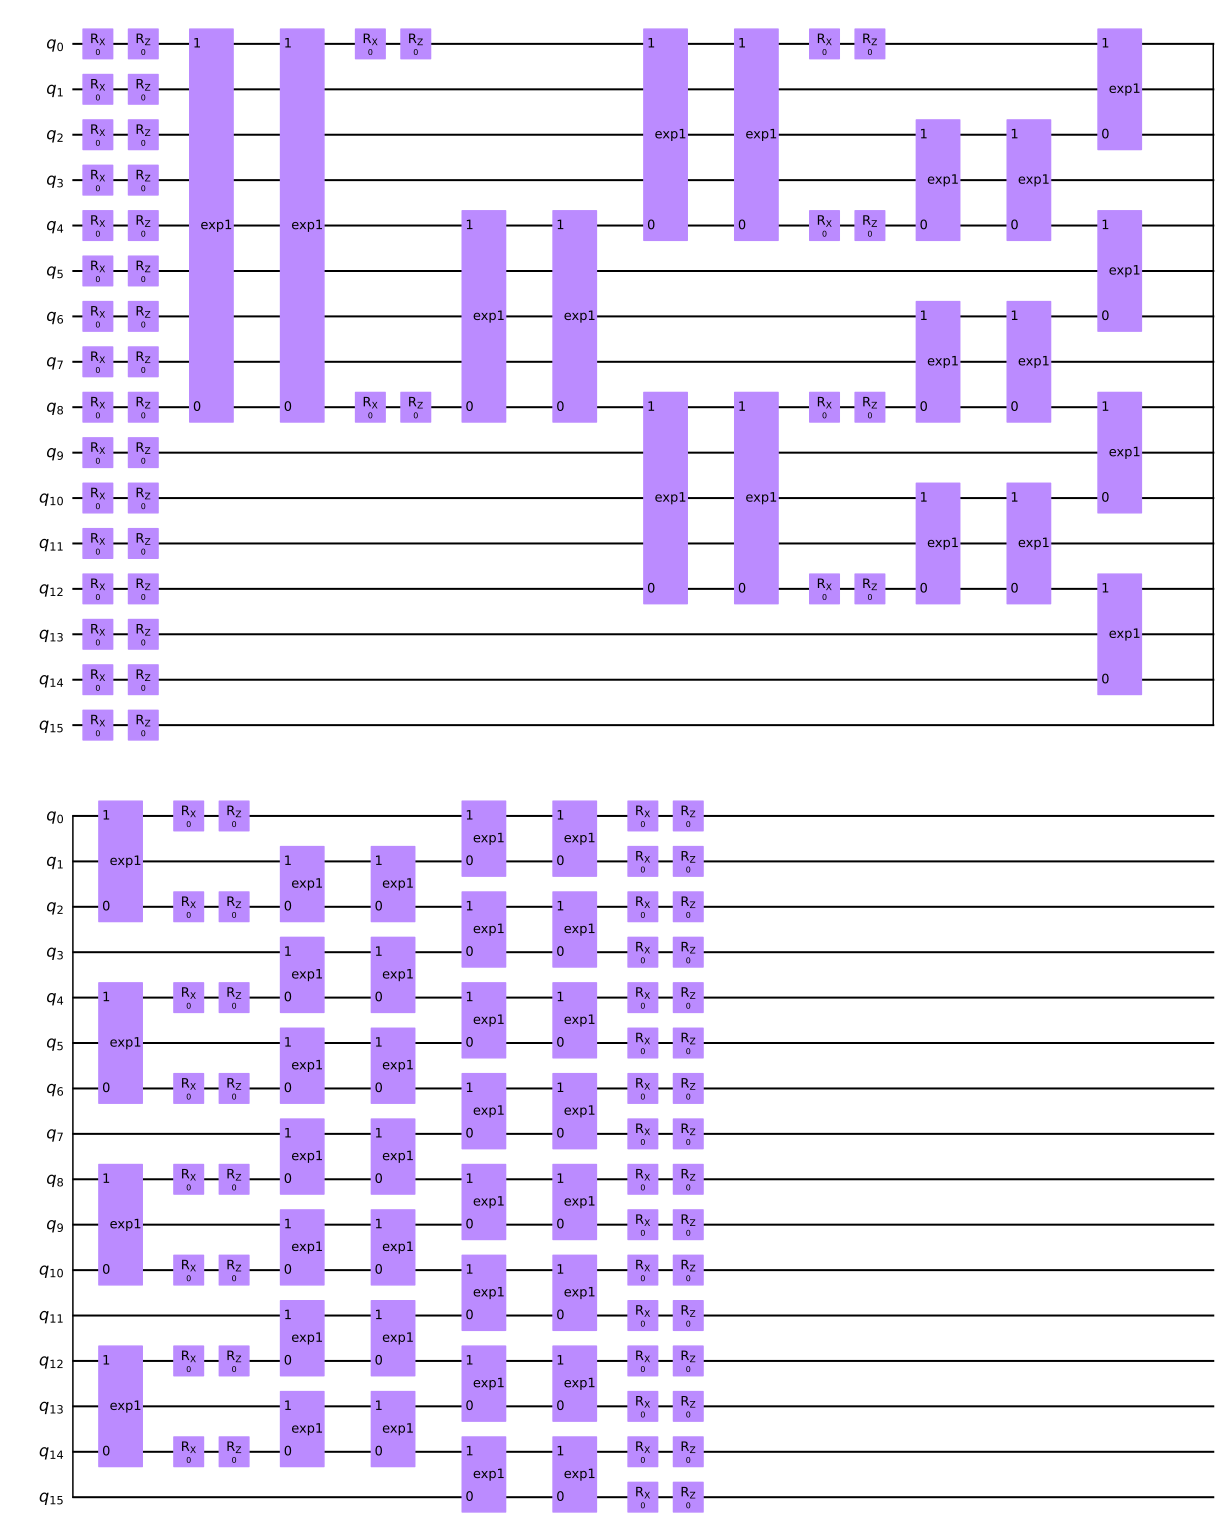

In [7]:
cirq, idx = MERA(np.zeros(1000), 16)
print(idx)
cirq.draw()

## train

In [9]:
MERA_tfim_vvag = tc.backend.jit(
    tc.backend.vectorized_value_and_grad(MERA)
)

def batched_train(n, batch=10, maxiter=10000, lr=0.005):
    params = tf.Variable(
        initial_value=tf.random.normal(
            shape=[batch, idx], stddev=1, dtype=getattr(tf, tc.rdtypestr)
        )
    )
    opt = tf.keras.optimizers.Adam(lr)
    lowest_energy = 1e5
    for i in range(maxiter):
        e, grad = MERA_tfim_vvag(params, n)
        opt.apply_gradients([(grad, params)])
        if tf.reduce_min(e)<lowest_energy:
            lowest_energy = tf.reduce_min(e)
        if i % 200 == 0:
            print(e)
    return lowest_energy

In [11]:
n = 16
with tf.device('/cpu:0'):
    energy = batched_train(n, batch=5, maxiter=2000, lr=0.007)

tf.Tensor([ 0.50356002 -0.25260815 -1.10719736 -2.87961363  0.13045823], shape=(5,), dtype=float64)
tf.Tensor([-19.60586234 -19.02354017 -19.16135046 -19.66902429 -19.0677275 ], shape=(5,), dtype=float64)
tf.Tensor([-19.73813651 -19.21869096 -19.35058496 -19.77485752 -19.68576536], shape=(5,), dtype=float64)
tf.Tensor([-19.74912952 -19.72231837 -19.75251978 -19.78946682 -19.71659073], shape=(5,), dtype=float64)
tf.Tensor([-19.75581954 -19.75128075 -19.78490097 -19.80075717 -19.74270718], shape=(5,), dtype=float64)
tf.Tensor([-19.76240036 -19.76988581 -19.79467965 -19.81116858 -19.75903467], shape=(5,), dtype=float64)
tf.Tensor([-19.77801074 -19.78409663 -19.80409029 -19.81734085 -19.76977616], shape=(5,), dtype=float64)
tf.Tensor([-19.79328029 -19.79263509 -19.81366423 -19.82037652 -19.77979084], shape=(5,), dtype=float64)
tf.Tensor([-19.80324335 -19.80029803 -19.8190512  -19.82276598 -19.7876707 ], shape=(5,), dtype=float64)
tf.Tensor([-19.81597487 -19.81076487 -19.82239657 -19.824623

## compare

In [12]:
# DMRG
import quimb
h = quimb.tensor.tensor_gen.MPO_ham_ising(n, j=4., bx=2., S=0.5, cyclic=False)  # Ising Hamiltonian in MPO form (number, zz interaction strenth, x-magnetic field strenth)
dmrg = quimb.tensor.tensor_dmrg.DMRG(h, bond_dims=[10, 20, 100, 100, 200], cutoffs=1e-13)
dmrg.solve(tol=1e-9, verbosity=1)
energy0 = dmrg.energy

#compare
print("\n")
print("DMRG solution: ", energy0)
print("MERA solution: ", energy.numpy())

SWEEP-1, direction=R, max_bond=(10/10), cutoff:1e-13


100%|##########################################| 15/15 [00:00<00:00, 143.86it/s]

Energy: -20.014253927726187 ... not converged.
SWEEP-2, direction=R, max_bond=(10/20), cutoff:1e-13



100%|##########################################| 15/15 [00:00<00:00, 294.12it/s]

Energy: -20.016387386841714 ... not converged.
SWEEP-3, direction=R, max_bond=(20/100), cutoff:1e-13



100%|##########################################| 15/15 [00:00<00:00, 360.85it/s]

Energy: -20.01638790043685 ... not converged.
SWEEP-4, direction=R, max_bond=(19/100), cutoff:1e-13



100%|##########################################| 15/15 [00:00<00:00, 300.00it/s]

Energy: -20.016387900481682 ... converged!


DMRG solution:  -20.016387900481682
MERA solution:  -19.826087706242852
